<a href="https://colab.research.google.com/github/duberii/pid-playground/blob/main/activities/Bias_in_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bias in Machine Learning**
---
Welcome to Particle Identification Playground! In this activity, you will learn about some best practices in machine learning!

**Before attempting this notebook, complete all of the activities in the Getting Started section and the Particle Identification Methods section. Also, be sure to complete the following notebooks from the Advanced Topics section before attempting this notebook:**
*   Working with Experimental Data
*   Confusion Matrices
*   Comparing PID Methods
*   Machine Learning Methods

**After completing this notebook, you will be able to:**
*   Define bias and overfitting
*   Identify signs of overfitting and bias in machine learning models
*   Implement practices to minimize bias when training a machine learning model

In [ ]:
#@title Run this cell before starting
!pip install-qqq pidp_tools
from pidp_tools import *
import pandas as pd
import numpy as np
from PIL import Image
import ipywidgets as widgets
from ipywidgets import interactive, fixed, widgets, HBox, VBox, Layout
from google.colab import output
import math
import sklearn.ensemble
import sklearn.inspection
import tqdm
import matplotlib.pyplot as plt
output.enable_custom_widget_manager()

particle_list = ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"]
!wget -q -O particle_data.hdf5 https://github.com/duberii/pid-playground/raw/main/data/particle_data.hdf5
particle_data = pd.read_hdf("particle_data.hdf5")
particle_data['Hypothesis'] = particle_data['Hypothesis'].apply(particle_list.index)
particle_data['Generated As'] = particle_data['Generated As'].apply(particle_list.index)
!wget -q -O low_momentum_particle_data.hdf5  https://github.com/duberii/pid-playground/raw/main/data/low_momentum_particle_data.hdf5
low_momentum_particle_data = pd.read_hdf("low_momentum_particle_data.hdf5")
low_momentum_particle_data['Hypothesis'] = low_momentum_particle_data['Hypothesis'].apply(particle_list.index)
low_momentum_particle_data['Generated As'] = low_momentum_particle_data['Generated As'].apply(particle_list.index)
small_low_momentum_particle_data = grab_events(low_momentum_particle_data, n_each=1000)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.8 MB/s eta 0:00:00


---
##**Overfitting**
---
Although machine learning is an extremely powerful tool, we need to be careful when using it, as it is very dependent on the data we use to train the model. The main concerns are two forms of overreliance on data: bias and overfitting. For simplicity, let's start by discussing **overfitting**.

Have you ever gotten a study guide for a test, and only used that study guide to prepare for the test? You get really good at solving the problems on the study guide, but unfortunately, the questions on the test are probably going to be different from the study guide. In machine learning, the training data is the study guide and the test data (or the real problem we are trying to solve) is the test. We say a model is **overfit** if it has extremely high accuracy on the training data, but has significantly worse performance when tested on data it was not trained on. Let's take a look at an example.

Below is a cell that will train a model to identify particles. When we create a confusion matrix by applying the model to the training dataset, we get this:

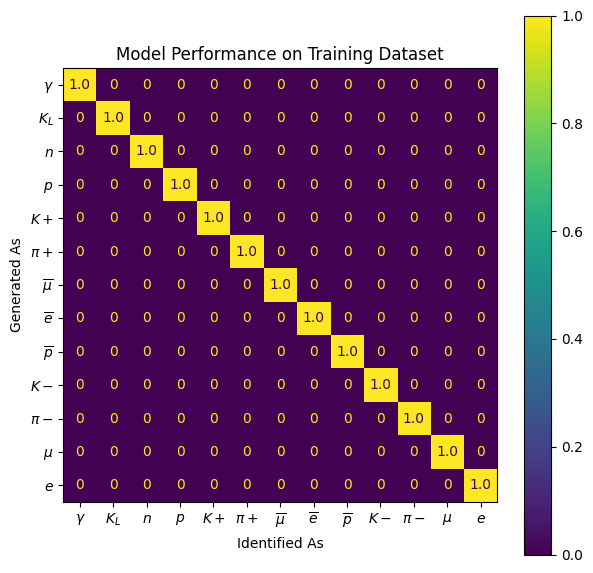

In [ ]:
# @title
train, test = split_df(small_low_momentum_particle_data, training_fraction = 0.2)

model = sklearn.ensemble.HistGradientBoostingClassifier(min_samples_leaf=1,max_leaf_nodes=1000,early_stopping=False,max_iter=1)#early_stopping=False,learning_rate=0.01)

labels = train['Generated As']
unlabeled_data = train.drop(['Generated As'], axis=1)

model.fit(unlabeled_data, labels)

ConfusionMatrix.from_model(model, train, title="Model Performance on Training Dataset")

This confusion matrix makes it seem like our model will do amazing when we go to test it on our test data. However, when we take a look at the model's perfomance on the test dataset (which it did not use for training), we get this:

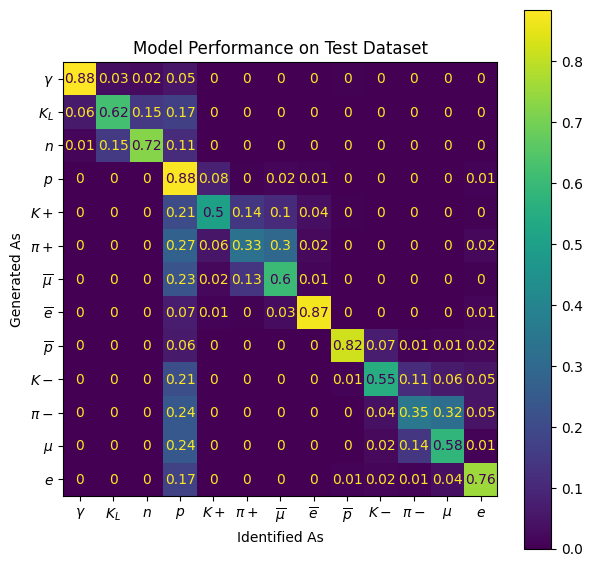

In [ ]:
# @title
ConfusionMatrix.from_model(model, test, title="Model Performance on Test Dataset")

As we can see, this model behaves very poorly on data it has never seen before. The model has essentially memorized the data in the training dataset, but the memorized data doesn't help it identify particles that it hasn't seen before. The only exceptions are the "easy" particles to identify (photons, electrons, and positrons), which tend to leave a pretty unique signal in the detector. Impressive performance on the training data and underwhelming performance on test data (or real data) is a key sign of overfitting.

A more technical way to detect overfitting is to closely monitor the loss when training our model. When we train our model, we are slowly decreasing the "training loss" (the value of the loss function when evaluated on the training dataset), and we would expect the "test loss" (the value of the loss function evaluated on the test dataset) to decrease as well. However, as our model is overfit, the training loss will keep decreasing (meaning the model gets more accurate on the training dataset), while the test loss starts to increase (meaning the model gets less accurate on the test data). This is another key sign that a model is overfitting.

Admittedly, the default values of the `sklearn.ensemble.HistGradientBoostingClassifier` are very good at preventing overfitting. However, it is still good to familiarize yourself with ways to prevent overfitting.

####**Question #1:**
---
Below is a graph of the training and test loss values for models with different values of `max_iter`. Based on the fact that a lower loss means the model performs better, what should our value of `max_iter` be to prevent overfitting?

Double click to edit this cell and answer the following question: Based on the fact that a lower loss means the model performs better, what should our value of max_iter be to prevent overfitting?

Text(0, 0.5, 'Loss')

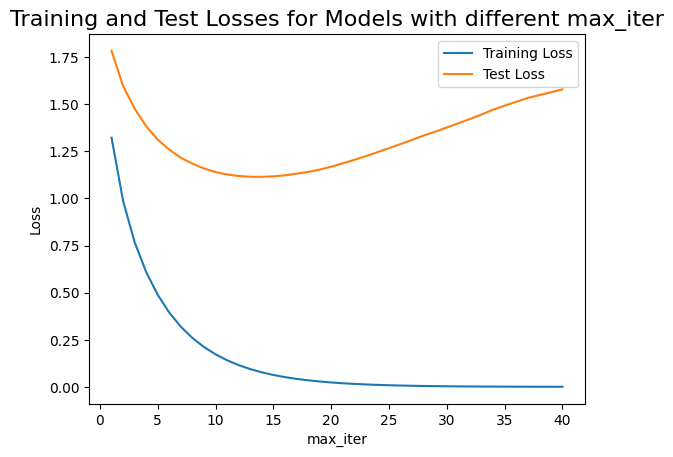

In [ ]:
# @title
train = grab_events(low_momentum_particle_data, n_each=50)
test = grab_events(low_momentum_particle_data,reverse=True, n_each=200)

model = sklearn.ensemble.HistGradientBoostingClassifier(early_stopping=False, min_samples_leaf=1, max_iter=40)

labels = train['Generated As']
unlabeled_data = train.drop(['Generated As'], axis=1)

model.fit(unlabeled_data, labels)

labels_test = test['Generated As']
unlabeled_data_test = test.drop(['Generated As'], axis=1)

train_accuracies = [sklearn.metrics.log_loss(np.array(labels),predictions) for predictions in model.staged_predict_proba(unlabeled_data)]
test_accuracies = [sklearn.metrics.log_loss(np.array(labels_test),predictions) for predictions in model.staged_predict_proba(unlabeled_data_test)]
plt.plot(list(range(1,len(train_accuracies)+1)),train_accuracies,label="Training Loss")
plt.plot(list(range(1,len(test_accuracies)+1)),test_accuracies, label= "Test Loss")
plt.legend()
plt.title("Training and Test Losses for Models with different max_iter", fontsize=16)

plt.xlabel("max_iter")
plt.ylabel("Loss")

#####**Solution:**

Overfitting happens when the test/validation loss (shown in orange) starts increasing, meaning the model is starting to perform worse on data it is not trained on. In this case, the test loss starts to increase when `max_iter` is about 13, so we would stop training this model after 13 iterations.

---
##**Preventing Overfitting**
---
Fortunately, preventing overfitting is not too difficult. There are tons of ways that we can change the way we train our model to prevent overfitting. **Regularization** is the process of designing our training process to reduce the chances of overfitting.



---
###**Increasing Training Sample Size**
---

Oftentimes, the easiest way to prevent overfitting is to increase the size of the dataset we use to train our model. The reason this usually works is because it introduces so much data that the model can't possibly memorize it all. Instead, it needs to find hidden trends in the data to be able to improve its performance on the training data, and these same hidden trends can be used to accurately identify particles in real data.

**Pros:** Because our data comes from simulations, it is fairly easy to get more data to train our models.

**Cons:** Increasing the amount of data we use to train our models makes the training take much longer.

---
###**Decreasing Model Size**
---

We breifly mentioned in the previous notebook that increasing the size of your model (by increasing `max_iter` or `max_leaf_nodes`, for example) will generally increase the accuracy of your model. However, if we make our model too big, we can get the opposite effect. Making our model too large can increase its ability to memorize the data we give it, which makes overfitting more likely. Therefore, an alternative to increasing the size of the training dataset is decreasing the size of the model, which will have a similar effect. Properties of the model that can be considered "model size" include:

*   max_iter (default value: 100)
*   max_leaf_nodes (default value: 31)
*   max_depth (default value: None, but the maximum depth of a model is limited by the maximum number of leaf nodes)

**Pros:** Decreasing the model size will decrease the amount of time it takes to train our model.

**Cons:** For complex problems (such as the particle identification problem), we need large models to be able to find the hidden trends in our data. Reducing the model size could greatly reduce the accuracy of our final model.

---
###**Early Stopping**
---

One of the most common regularization methods is early stopping, which stops training a model once it starts to overfit. Early stopping is actually enabled by default in Scikit-learn.

As mentioned earlier, overfitting can be detected when the training loss decreases, but the test loss starts to increase. However, we want to make sure our test data is not used at all in the training process (which helps make sure the model has never seen our test data before). Instead of using our test data during the training process, we usually divide our training data into two smaller dataset. A smaller training dataset and a **validation** dataset. The training dataset is used to train the model, while the validation dataset is used to calculate the loss on a collection of data that is not directly used in the training, which allows us to detect overfitting. Once the validation loss starts to increase, we stop the training. This is why the "number of iterations" is called `max_iter`: If we stop training early, we may not actually need all of those iterations.

**Pros:** Early stopping is an extremely powerful way to prevent overfitting. It is usually enabled by deafult, and you would only want to turn it off in extremely rare circumstances.

**Cons:** Because we are designating part of our training data as validation data, the size of the dataset that we are using to actually train our model is slightly smaller. You can change the amound of data used for validation by changing the `validation_fraction` argument of the `sklearn.ensemble.HistGradientBoostingClassifier()` object (by default, 10% of the training data is used for validation). However, decreasing the size of the validation dataset decreases the ability of the model to detect overfitting, so be careful when changing the validation fraction.

---
###**L2 Regularization**
---

To understand L2 regularization, we need to remember how predictions are made by boosted decision trees. When we make a prediction with a boosted decision tree, we provide the same input data to every tree we trained, and each of them make a prediction. These predictions are like "votes" that the trees make to contribute to the final prediction.

However, certain votes are more valuable than other votes. Based on how confident the tree is in its prediction, the vote becomes more or less important. This information is stored in a property of the tree called its **weight**. The larger the weight, the more important that tree is in determining the final prediction. If all the weights are equal, the final prediction is made using a popular vote- each of the trees votes for a prediction, and the prediction made by the majority of the trees wins. If one tree has a large weight, and the rest of the trees have a weight of 0, the model is a dictatorship- only one of the trees makes all of the decisions, and none of the other trees are allowed to contribute to the final prediction. In practice, the weights are somewhere in between: all of the trees have some type of vote, but the trees that are more accurate in their predictions are rewarded with a larger weight.

L2 regularization adds a term to our loss function that is proportional to these weights (more preciely, the square sum of these weights). This makes complex models (models with lots of large weights) have a higher loss, meaning simpler models are favored. These simpler models are less prone to overfitting. We can change how strong the penalty for large models is with the **L2 regularization parameter**. By default, the L2 regularization parameter for our model is 0, meaning the L2 regularization term doesn't contribute to the loss function. There is no maximum L2 regularization parameter, but if we make the L2 regularization parameter too large, we can completely overshadow the loss from the training data, which makes it so that our model can't learn from the training data. In practice, we would train a model multiple times with different L2 regularization parameters, and pick the value that produces the best results while still avoiding overfitting.

We can change the L2 regularization parameter using the `l2_regularization` argument in our model function.

**Pros:** L2 regularization is extremely powerful at preventing overfitting.

**Cons:** L2 regularization can slightly increase training time. Also, setting the L2 regularization parameter to a number that is too large can severely impact model accuracy.

---
###**Setting Minimum Samples Per Leaf**
---

The final method of regularization is requiring a minimum number of samples to create a leaf. In other words, we tell our model it can't create a leaf to identify 1 or 2 particles. This forces the model to look for more generalizable trends to make cuts on instead of identifying particles one at a time and memorizing our training dataset. You can change the required number of samples per leaf by setting the `min_samples_leaf` argument when creating your model. The default value is 20, meaning a leaf will not be created unless it classifies 20 or more particles (rows of the dataframe) at the same time.

**Pros:** Setting a minimal number of samples per leaf improves the generalizability of the model (and thus decreases the likelihood of overfitting)

**Cons:** Setting a minimal number of samples per leaf will generally make each tree smaller, which may reduce the accuracy of our model. This is particularly harmful for small datasets, so reducing the minimum number of samples per leaf may be helpful for smaller dataset.

---
##**Bias**
---
**Bias** generally refers to the tendency of a model to give unexpected results. Bias is introduced when we make incorrect assumptions as we are preparing our training and test data, which can lead to impossibly good model accuracy or unexpectedly bad model accuracy.

For example, let's say we want to train a model and we write the following code:

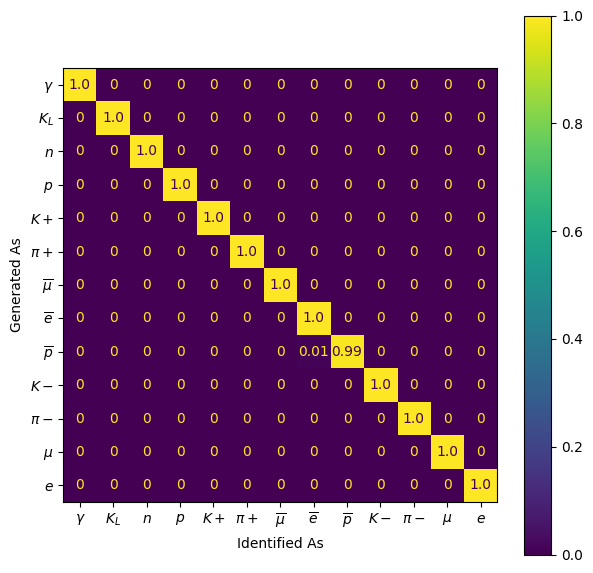

In [ ]:
train, test = split_df(small_low_momentum_particle_data)

model = sklearn.ensemble.HistGradientBoostingClassifier(max_iter=10)

labels = train['Generated As']

model.fit(train, labels)

ConfusionMatrix.from_model(model,test)

These results are suspicious- it's not possible that our model is able to identify particles with 100% accuracy. One way to diagnose what is wrong with our model is to check **feature importance**. Feature importance is a way for us to determine what features (columns of our dataset) are particularly helpful for the model to classify particles. We can estimate feature importance using the `feature_importance` function. The general syntax is:

```
feature_importance(model, test_data)
```

When we use this function on our model, we get the following:

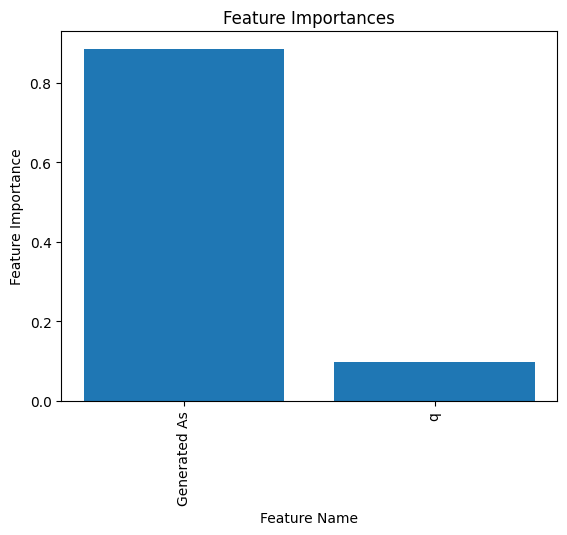

In [ ]:
feature_importance(model, test)

This bar graph tells us that the most important feature for the model is the `Generated As` column. However, we weren't supposed to include the `Generated As` column in our training data! This gives us an idea of what we did wrong when we trained our data- we introduced a feature that gave the answer away, so our model just learned to copy the answer! By including the `Generated As` feature in our training data, we introduced bias that made our model perform much better than it should have.

Not all forms of bias are this easy to fix. Some forms of bias are deeply integrated into the way we format our data, so it is good to regularly check these feature importances to see if there are any signs of bias. In general, making sure our test data is formatted exactly how real data would be formatted minimizes bias in the testing process, so all we would need to do is ensure our training data doesn't introduce any bias.

In general, when making changes to the way you operate your model or what training data you supply you need to closely examine the changes you'd like to make to ensure you are not introducing any bias.

####**Question #2:**
---
Below is the code provided in the example above. Modify the code below to remove the primary source of bias.

In [ ]:
train, test = split_df(small_low_momentum_particle_data)

model = sklearn.ensemble.HistGradientBoostingClassifier(max_iter=10)

labels = train['Generated As']

model.fit(train, labels)

feature_importance(model, test)

#####**Solution:**

Because the main source of bias is the inclusion of the `Generated As` feature in the training data, all we need to do is drop the `Generated As` column from the training sample before training.

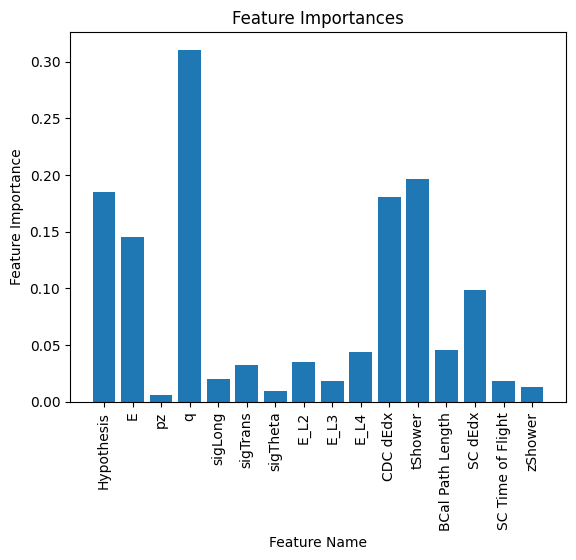

In [ ]:
train, test = split_df(small_low_momentum_particle_data)

model = sklearn.ensemble.HistGradientBoostingClassifier(max_iter=10)

labels = train['Generated As']
unlabeled_data = train.drop(['Generated As'], axis=1) #This is the line of code we added

model.fit(unlabeled_data, labels)  #Change the training dataset to the unlabeled data

feature_importance(model, test)

As we see here, the feature importances are much more distributed, which tells us that the model is using all of the available data to make its prediction. No one feature is used to make a decision.

####**Question #3:**
---
Making a smaller training dataset will speed up training. Let's say we want to reduce the size of our training set so we can train our model faster. Here is one idea to reduce the size of our training data.

Our training data currently consists of all of the hypotheses for charged particles. To reduce the size of our training dataset, we can train our model on only the "correct" hypothesis.

Write code in the cell below to create a training dataset that only contains the hypotheses that match the generated particle type.

**Note:** Because neutral particles have "No ID" in the hypothesis column, they will probably be excluded from our training sample using most methods of solving this problem. To avoid this, we have included a line of code that appends the neutral particles at the end of the dataframe. All you need to do is complete the line of code for the charged particles.

In [ ]:
train, test = split_df(low_momentum_particle_data, training_fraction=0.99)

charged_particles_training = #Complete this code

neutral_particles_training = train.loc[train['q']==0]

train = pd.concat([charged_particles_training, neutral_particles_training], ignore_index=True)

#####**Solution:**

In [ ]:
train, test = split_df(low_momentum_particle_data, training_fraction = 0.99)

charged_particles_training = train.loc[train['Hypothesis']==train['Generated As']]

neutral_particles_training = train.loc[train['q']==0]

train = pd.concat([charged_particles_training, neutral_particles_training], ignore_index=True)

####**Question #4:**
---
Write code in the cell below to train a model based on the training and test data you created in Question #3 and create a bar graph of its feature importances. Use the default model (no need to change any of its properties). Does this model show any signs of bias?

**Note:** This cell will take a few minutes to run.

Double click to edit this cell and answer the following question: Does this model show any signs of bias?

In [ ]:
#Complete this code

#####**Solution:**

As we see in the plot below, the hypothesis feature is extremely important to this model. If we think about what we did during training, this makes sense. We have essentially made it so that the hypothesis column contains the correct answer (except for neutral particles, which it needs to learn to distinguish). For charged particles, all the model needs to do is look at the hypothesis column to find the right answer. For neutral particles, however, the model needs to rely on other features, such as energy and shower properties.

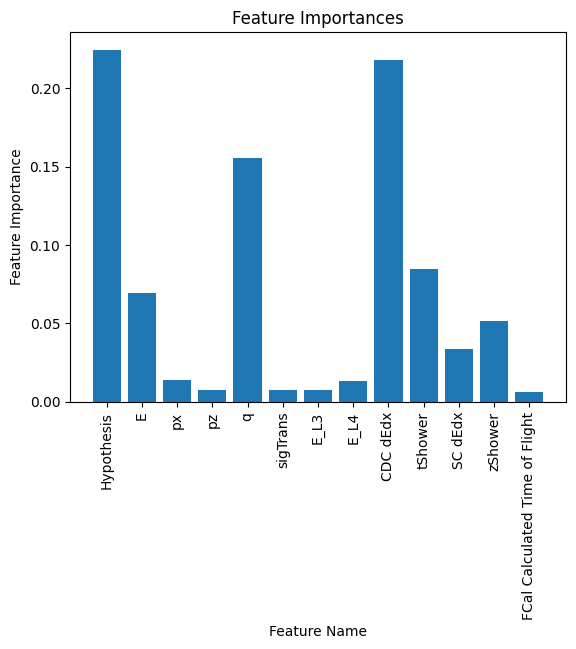

In [ ]:
model = sklearn.ensemble.HistGradientBoostingClassifier()

labels = train['Generated As']
unlabeled_data = train.drop(['Generated As'], axis=1)

model.fit(unlabeled_data, labels)

feature_importance(model, test)

####**Question #5:**
---
As we saw in Question #4, the hypothesis is introducing bias, since we required the hypothesis to match the generated particle type. Write code in the cell below to train another model (using the default parameters) on training data that does not contain a `Hypothesis` column.

In [ ]:
#Complete this code

#####**Solution:**

In [ ]:
model = sklearn.ensemble.HistGradientBoostingClassifier()

labels = train['Generated As']
unlabeled_data = train.drop(['Generated As','Hypothesis'], axis=1)

model.fit(unlabeled_data, labels)

HistGradientBoostingClassifier()

####**Question #6:**
---
We are now ready to evaluate our model on our test data, but we need to do it slightly differently. We have trained a model that functions a lot like our manual PID functions. Our model is really good at recognizing the "correct" hypothesis. However, it will be really bad at recognizing the "incorrect hypotheses. For this reason, we need to only consider the mases where the prediction matches the hypothesis. To force our functions (`feature_importance` or `ConfusionMatrix.from_model`) to use this "hypothesis matching," we can use the optional `match_hypothesis` option, which can be set to be `True` or `False`. For example, to create a feature importance graph using the matching hypotheses method, we could write:
```
feature_importance(model, test, match_hypothesis=True)
```

Write code in the cell below to create a confusion matrix based on the model you trained in Question #5 using the "matching hypotheses" method.

In [ ]:
ConfusionMatrix.from_model(#Complete this code)

#####**Solution:**

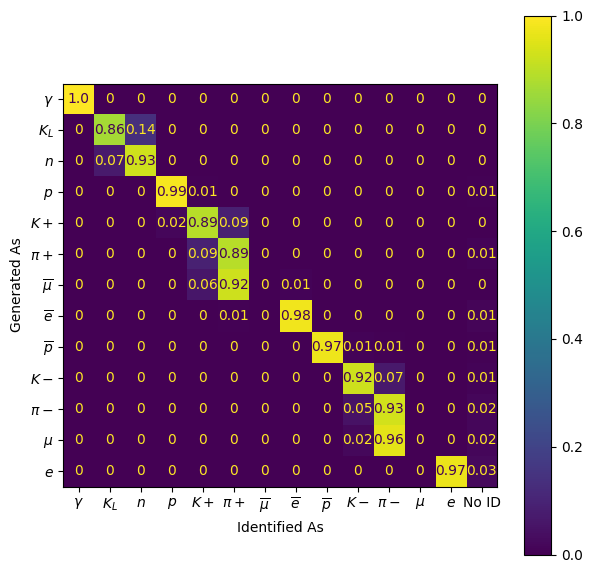

In [ ]:
ConfusionMatrix.from_model(model, test, match_hypothesis = True)

####**Question #7:**
---
In Question #6, you should have found that this machine learning model is extremely accurate for all particles except for muons. In fact, no particle is every classified as a muon! Based on the requirement that a particle is only identified if the prediction of the model matches the hypothesis of the track it is looking at, why aren't any particles identified as muons?

Double click to edit this cell and answer the following question: Why aren't any particles identified as muons?

#####**Solution:**

Particles can't be identified as muons in this scheme because there is no muon hypothesis! Muons behave so similarly to pions in most cases that it is not even worth creating a separate hypothesis just for muons. This is a form of bias we have introduced (which incorrectly assumed that there is a muon hypothesis), which hurt our ability to identify muons.

This bias was introduced as early as Question #3, in which we created a dataframe with only particles whose true identity matched the hypothesis. Since there are no muon or antimuon hypotheses, our training data didn't contain any muon/antimuon events, so even if we had a way to identify a particle as a muon/antimuon, our model would be really bad at it, because we didn't give it any examples in the training dataset.

To get around this, we can consider it a "match" when the hypothesis is a pion, but the identified particle is a muon. This way, we are still able to identify muons using our model and the matching hypothesis assumption, even though we don't have a muon hypothesis. However, it is much easier to work with models using our original method (where `match_hypothesis` was `False`), so we recommend sticking with that method going forward.